In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class learner(nn.Module):
    def __init__(self,in_dim,out_dim,h=[100,50,20,20]):
        super(learner,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.predictor = nn.Sequential(nn.Linear(in_dim,h[0]),
                                        nn.ELU(),
                                        nn.Linear(h[0],h[1]),
                                        nn.ELU(),
                                        nn.Linear(h[1],h[2]),
                                        nn.ELU(),
                                        nn.Linear(h[2],h[3]),
                                        nn.ELU(),
                                        nn.Linear(h[3],out_dim),
                                        nn.LogSoftmax(dim=1))
        
    def forward(self,X):
        return self.predictor(X)


class ensemble(nn.Module):
    def __init__(self,in_dim,out_dim,num_learners=30,h=None):
        super(ensemble,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_learners = num_learners
        self.ensemble = nn.ModuleList([learner(self.in_dim,self.out_dim) for idx in range(self.num_learners)])

    def forward(self,X,idx=None):
        if idx is not None:
            y_pred = self.ensemble[idx](X)
        
        else:
            y_pred = torch.zeros(out_dim)
            for model in self.ensemble:
                y_pred += model(X) / self.num_learners
        
        return y_pred





In [3]:
def backdoor_attack(X,y,method='naive',target_class=2):

    for idx in range(X.shape[0]):
        if method=='naive':
            X[idx,0,:3,:3] = 0
            y[idx] = target_class

    return X, y
    

In [4]:
# Transform to normalized Tensors 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('.\\data\\', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('.\\data\\', train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

train_dataset_array = next(iter(train_loader))[0].numpy()
test_dataset_array = next(iter(test_loader))[0].numpy()

train_labels_array = next(iter(train_loader))[1].numpy()
test_labels_array = next(iter(test_loader))[1].numpy()

In [5]:
BACKDOOR_PERC = .01

backdoor_train_dataset_array = train_dataset_array[:int(train_dataset_array.shape[0]*.1)]
backdoor_train_labels_array = train_labels_array[:int(train_dataset_array.shape[0]*.1)]
clean_train_dataset_array = train_dataset_array[int(train_dataset_array.shape[0]*.1):]
clean_train_labels_array = train_labels_array[int(train_dataset_array.shape[0]*.1):]

backdoor_test_dataset_array = test_dataset_array[:int(test_dataset_array.shape[0]*.1)]
backdoor_test_labels_array = test_labels_array[:int(test_dataset_array.shape[0]*.1)]
clean_test_dataset_array = test_dataset_array[int(test_dataset_array.shape[0]*.1):]
clean_test_labels_array = test_labels_array[int(test_dataset_array.shape[0]*.1):]

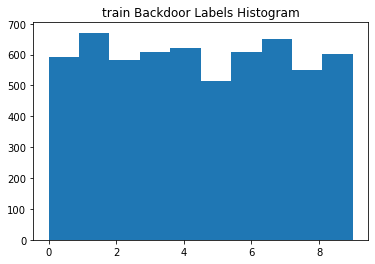

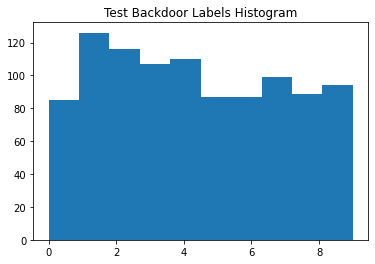

In [6]:
#Check for even distribution
plt.hist(backdoor_train_labels_array)
plt.title('train Backdoor Labels Histogram')
plt.show()

plt.hist(backdoor_test_labels_array)
plt.title('Test Backdoor Labels Histogram')
plt.show()

In [7]:
#Backdoor and Create our composite dataset
N_LEARNERS = 30
backdoor_train_dataset_array, backdoor_train_labels_array = backdoor_attack(backdoor_train_dataset_array, backdoor_train_labels_array)
backdoor_test_dataset_array, backdoor_test_labels_array = backdoor_attack(backdoor_test_dataset_array, backdoor_test_labels_array)

contaminated_train_data = np.vstack([backdoor_train_dataset_array,clean_train_dataset_array])
contaminated_train_labels = np.hstack([backdoor_train_labels_array,clean_train_labels_array])

shuffle_train_idxs = np.arange(contaminated_train_data.shape[0])
np.random.shuffle(shuffle_train_idxs)

X_train = contaminated_train_data[shuffle_train_idxs,:,:,:]
y_train = contaminated_train_labels[shuffle_train_idxs]

X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)

BATCH_SIZE=20
dset_list = [TensorDataset(tensor,label_tensor) for tensor,label_tensor in zip(torch.tensor_split(X_train_t,N_LEARNERS,dim=0),torch.tensor_split(y_train_t,N_LEARNERS,dim=0))]
data_loader_list = [DataLoader(dset,batch_size=BATCH_SIZE,shuffle=True) for dset in dset_list]


In [11]:
model = ensemble(28*28,10,num_learners=N_LEARNERS)
optimizer = torch.optim.AdamW(model.parameters())
nll_loss = nn.NLLLoss()
loss_hist_dict = {}

In [12]:
from tqdm import tqdm
#Warm-up Loop
N_EPOCHS = 20

for idx,loader in enumerate(data_loader_list):
    loss_hist_dict[idx] = []
    for epoch in range(1,N_EPOCHS):
        epoch_loss = 0.0

        for X_batch, y_batch in loader:
            X_batch = X_batch.view(-1,28*28)
            y_batch = y_batch.long()
            optimizer.zero_grad()
            y_pred = model(X_batch,idx)
            loss = nll_loss(y_pred,y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        loss_hist_dict[idx].append(epoch_loss)
        print(f'loader: {idx} epoch: {epoch} loss: {epoch_loss}')

        

loader: 0 epoch: 1 loss: 147.96572050452232
loader: 0 epoch: 2 loss: 75.71333307027817
loader: 0 epoch: 3 loss: 59.067860409617424
loader: 0 epoch: 4 loss: 45.64425355195999
loader: 0 epoch: 5 loss: 35.49629706144333
loader: 0 epoch: 6 loss: 26.654766611754894
loader: 0 epoch: 7 loss: 16.932926943525672
loader: 0 epoch: 8 loss: 10.03421233035624
loader: 0 epoch: 9 loss: 7.3502311538904905
loader: 0 epoch: 10 loss: 5.6944917410146445
loader: 0 epoch: 11 loss: 5.786312948446721
loader: 0 epoch: 12 loss: 3.3356454557506368
loader: 0 epoch: 13 loss: 1.811400288483128
loader: 0 epoch: 14 loss: 0.7668972457177006
loader: 0 epoch: 15 loss: 0.9846015764633194
loader: 0 epoch: 16 loss: 1.5683553725248203
loader: 0 epoch: 17 loss: 1.461870631959755
loader: 0 epoch: 18 loss: 0.36902277551416773
loader: 0 epoch: 19 loss: 0.17289677595545072
loader: 1 epoch: 1 loss: 148.36838853359222
loader: 1 epoch: 2 loss: 77.25570204854012
loader: 1 epoch: 3 loss: 53.60187338292599
loader: 1 epoch: 4 loss: 34.9

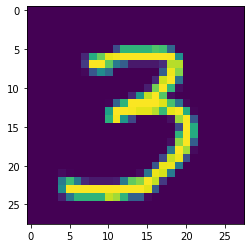

In [ ]:
plt.imshow(torch.tensor_split(X_train_t,30,dim=0)[0].detach().numpy()[0,0,:,:])

In [ ]:
y_pred.shape

torch.Size([20, 10])

In [ ]:
y_batch.long()

tensor([1, 7, 5, 1, 3, 0, 2, 1, 7, 3, 1, 4, 7, 3, 7, 7, 8, 2, 3, 7])